# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


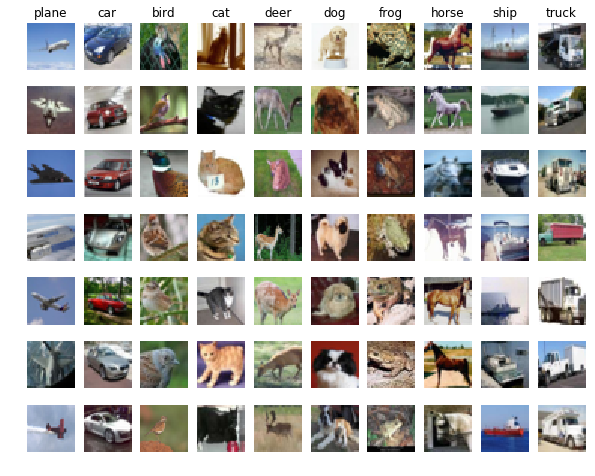

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


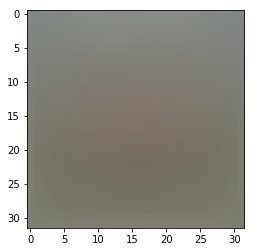

In [9]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [10]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: {}'.format(loss))

loss: 9.189020868124684


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [13]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 5.689076 analytic: 5.689076, relative error: 4.639340e-12
numerical: -35.258475 analytic: -35.258475, relative error: 3.041803e-12


numerical: -4.260368 analytic: -4.260368, relative error: 1.339147e-10
numerical: 7.772301 analytic: 7.772301, relative error: 1.177545e-12


numerical: 15.143714 analytic: 15.143714, relative error: 3.920809e-11
numerical: -12.524178 analytic: -12.524178, relative error: 1.200768e-12


numerical: 2.952296 analytic: 2.952296, relative error: 1.080779e-11
numerical: -0.001907 analytic: -0.001907, relative error: 2.537902e-07


numerical: -11.752873 analytic: -11.752873, relative error: 1.798881e-11
numerical: 19.071582 analytic: 19.071582, relative error: 1.077396e-11


numerical: 32.459783 analytic: 32.454926, relative error: 7.482525e-05
numerical: -5.308764 analytic: -5.301545, relative error: 6.803254e-04
numerical: -14.058334 analytic: -14.047501, relative error: 3.854439e-04


numerical: 3.996194 analytic: 3.996126, relative error: 8.452218e-06
numerical: 19.561867 analytic: 19.566856, relative error: 1.274957e-04
numerical: -10.051656 analytic: -10.047337, relative error: 2.148558e-04


numerical: 23.483171 analytic: 23.477628, relative error: 1.180231e-04
numerical: 36.945238 analytic: 36.943818, relative error: 1.921503e-05
numerical: -13.496912 analytic: -13.492218, relative error: 1.739242e-04


numerical: 19.247694 analytic: 19.245764, relative error: 5.014677e-05


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *The max function is not differentiable when sj-syi+delta is less than 0. At the kink, the finite difference, h, calculates a different gradient than the one in the analytical gradient. At this point, the gradient is very small, and so it is not much of a concern.*

In [14]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.189021e+00 computed in 0.095283s
Vectorized loss: 9.189021e+00 computed in 0.006250s
difference: -0.000000


In [15]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in {}s'.format((toc - tic)))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in {}s'.format((toc - tic)))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.05028367042541504s
Vectorized loss and gradient: computed in 0.005982160568237305s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [16]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 795.752352


iteration 100 / 1500: loss 475.713251


iteration 200 / 1500: loss 288.044624


iteration 300 / 1500: loss 175.343581


iteration 400 / 1500: loss 107.950600


iteration 500 / 1500: loss 67.394658


iteration 600 / 1500: loss 42.463956


iteration 700 / 1500: loss 28.071493


iteration 800 / 1500: loss 18.365028


iteration 900 / 1500: loss 12.853687


iteration 1000 / 1500: loss 9.934231


iteration 1100 / 1500: loss 8.387328


iteration 1200 / 1500: loss 7.609654


iteration 1300 / 1500: loss 6.143756


iteration 1400 / 1500: loss 5.744329


That took 4.015304s


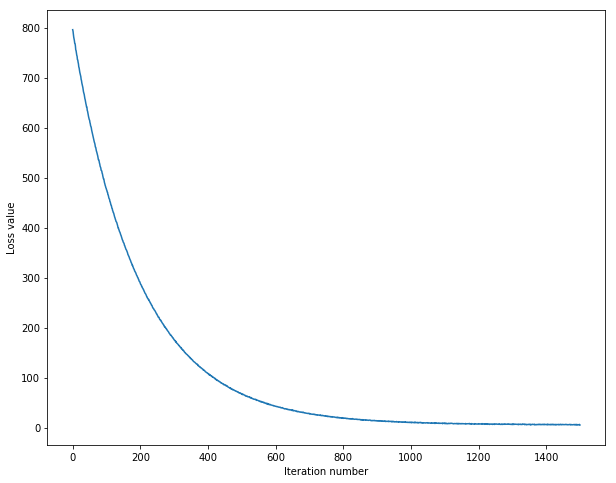

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.382612
validation accuracy: 0.388000


training accuracy: 0.1826734693877551
validation accuracy: 0.186


training accuracy: 0.17987755102040817
validation accuracy: 0.173


training accuracy: 0.20122448979591837
validation accuracy: 0.2


training accuracy: 0.1996326530612245
validation accuracy: 0.223


training accuracy: 0.17330612244897958
validation accuracy: 0.196


training accuracy: 0.16087755102040815
validation accuracy: 0.179


training accuracy: 0.191265306122449
validation accuracy: 0.229


training accuracy: 0.18722448979591838
validation accuracy: 0.184


training accuracy: 0.1712857142857143
validation accuracy: 0.172


training accuracy: 0.17971428571428572
validation accuracy: 0.188


training accuracy: 0.21520408163265306
validation accuracy: 0.235


training accuracy: 0.1956938775510204
validation accuracy: 0.205


training accuracy: 0.1933061224489796
validation accuracy: 0.196


training accuracy: 0.1663265306122449
validation accuracy: 0.164


training accuracy: 0.17122448979591837
validation accuracy: 0.196


training accuracy: 0.1984081632653061
validation accuracy: 0.2


training accuracy: 0.219734693877551
validation accuracy: 0.223


training accuracy: 0.18924489795918367
validation accuracy: 0.198


training accuracy: 0.16951020408163264
validation accuracy: 0.184


training accuracy: 0.185
validation accuracy: 0.165


training accuracy: 0.16275510204081634
validation accuracy: 0.133


training accuracy: 0.1353061224489796
validation accuracy: 0.139


training accuracy: 0.17944897959183673
validation accuracy: 0.176


training accuracy: 0.19428571428571428
validation accuracy: 0.197


training accuracy: 0.17926530612244898
validation accuracy: 0.192


training accuracy: 0.153734693877551
validation accuracy: 0.147


training accuracy: 0.16138775510204081
validation accuracy: 0.181


training accuracy: 0.17242857142857143
validation accuracy: 0.173


training accuracy: 0.18177551020408164
validation accuracy: 0.193


training accuracy: 0.16926530612244897
validation accuracy: 0.171


training accuracy: 0.12148979591836735
validation accuracy: 0.098


training accuracy: 0.12030612244897959
validation accuracy: 0.118


training accuracy: 0.1553877551020408
validation accuracy: 0.165


training accuracy: 0.15151020408163265
validation accuracy: 0.164


training accuracy: 0.05318367346938775
validation accuracy: 0.05


training accuracy: 0.15075510204081632
validation accuracy: 0.149


training accuracy: 0.13981632653061224
validation accuracy: 0.147


training accuracy: 0.1890408163265306
validation accuracy: 0.185


training accuracy: 0.12136734693877552
validation accuracy: 0.113


training accuracy: 0.10289795918367346
validation accuracy: 0.123


training accuracy: 0.14461224489795918
validation accuracy: 0.134


training accuracy: 0.14548979591836736
validation accuracy: 0.132


training accuracy: 0.16779591836734695
validation accuracy: 0.164


training accuracy: 0.15189795918367346
validation accuracy: 0.141


training accuracy: 0.0956530612244898
validation accuracy: 0.103


training accuracy: 0.1359795918367347
validation accuracy: 0.15


training accuracy: 0.15285714285714286
validation accuracy: 0.164


training accuracy: 0.16385714285714287
validation accuracy: 0.173


training accuracy: 0.19979591836734695
validation accuracy: 0.203


training accuracy: 0.13273469387755102
validation accuracy: 0.143


training accuracy: 0.15897959183673468
validation accuracy: 0.144


training accuracy: 0.15585714285714286
validation accuracy: 0.16


training accuracy: 0.15555102040816327
validation accuracy: 0.174


training accuracy: 0.16071428571428573
validation accuracy: 0.17


training accuracy: 0.16679591836734695
validation accuracy: 0.173


training accuracy: 0.13669387755102042
validation accuracy: 0.152


training accuracy: 0.17893877551020407
validation accuracy: 0.205


training accuracy: 0.12346938775510204
validation accuracy: 0.119


training accuracy: 0.16440816326530613
validation accuracy: 0.188


training accuracy: 0.1536122448979592
validation accuracy: 0.134


training accuracy: 0.21106122448979592
validation accuracy: 0.217


training accuracy: 0.20022448979591836
validation accuracy: 0.206


training accuracy: 0.1966530612244898
validation accuracy: 0.204


training accuracy: 0.19077551020408162
validation accuracy: 0.2


training accuracy: 0.1519795918367347
validation accuracy: 0.153


training accuracy: 0.20648979591836736
validation accuracy: 0.202


training accuracy: 0.21744897959183673
validation accuracy: 0.222


training accuracy: 0.2189591836734694
validation accuracy: 0.22


training accuracy: 0.19414285714285714
validation accuracy: 0.175


training accuracy: 0.17051020408163264
validation accuracy: 0.194


training accuracy: 0.18383673469387754
validation accuracy: 0.191


training accuracy: 0.17783673469387756
validation accuracy: 0.184


training accuracy: 0.16830612244897958
validation accuracy: 0.176


training accuracy: 0.13708163265306123
validation accuracy: 0.141


training accuracy: 0.1363061224489796
validation accuracy: 0.15


training accuracy: 0.1743469387755102
validation accuracy: 0.175


training accuracy: 0.1662857142857143
validation accuracy: 0.172


training accuracy: 0.1343061224489796
validation accuracy: 0.144


training accuracy: 0.17016326530612244
validation accuracy: 0.203


training accuracy: 0.1389795918367347
validation accuracy: 0.149


training accuracy: 0.17851020408163265
validation accuracy: 0.215


training accuracy: 0.16448979591836735
validation accuracy: 0.152


training accuracy: 0.1696326530612245
validation accuracy: 0.152


training accuracy: 0.14320408163265305
validation accuracy: 0.13


training accuracy: 0.14673469387755103
validation accuracy: 0.157


training accuracy: 0.10214285714285715
validation accuracy: 0.087


training accuracy: 0.13179591836734694
validation accuracy: 0.144


training accuracy: 0.1589183673469388
validation accuracy: 0.169


training accuracy: 0.11379591836734694
validation accuracy: 0.093


training accuracy: 0.10579591836734693
validation accuracy: 0.109


training accuracy: 0.1637142857142857
validation accuracy: 0.186


training accuracy: 0.19648979591836735
validation accuracy: 0.198


training accuracy: 0.19391836734693876
validation accuracy: 0.207


training accuracy: 0.195
validation accuracy: 0.193


training accuracy: 0.16779591836734695
validation accuracy: 0.155


training accuracy: 0.17706122448979592
validation accuracy: 0.189


training accuracy: 0.18742857142857142
validation accuracy: 0.202


training accuracy: 0.22955102040816328
validation accuracy: 0.241


training accuracy: 0.1950204081632653
validation accuracy: 0.198


training accuracy: 0.16718367346938776
validation accuracy: 0.176


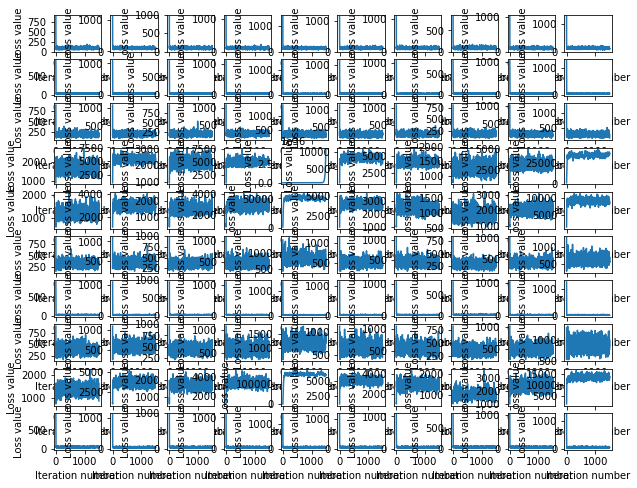

lr 6.254481e-06 reg 2.594943e+04 train accuracy: 0.218959 val accuracy: 0.220000
lr 6.254481e-06 reg 2.818621e+04 train accuracy: 0.211061 val accuracy: 0.217000
lr 6.254481e-06 reg 3.014328e+04 train accuracy: 0.196653 val accuracy: 0.204000
lr 6.254481e-06 reg 3.237477e+04 train accuracy: 0.194143 val accuracy: 0.175000
lr 6.254481e-06 reg 3.366478e+04 train accuracy: 0.217449 val accuracy: 0.222000
lr 6.254481e-06 reg 3.463239e+04 train accuracy: 0.190776 val accuracy: 0.200000
lr 6.254481e-06 reg 3.491853e+04 train accuracy: 0.200224 val accuracy: 0.206000
lr 6.254481e-06 reg 3.661250e+04 train accuracy: 0.206490 val accuracy: 0.202000
lr 6.254481e-06 reg 4.005752e+04 train accuracy: 0.170510 val accuracy: 0.194000
lr 6.254481e-06 reg 4.382794e+04 train accuracy: 0.151980 val accuracy: 0.153000
lr 7.154010e-06 reg 2.594943e+04 train accuracy: 0.189245 val accuracy: 0.198000
lr 7.154010e-06 reg 2.818621e+04 train accuracy: 0.215204 val accuracy: 0.235000
lr 7.154010e-06 reg 3.014328

In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
NUM_STEPS = 10
learning_rates = [1e-7, 5e-5]
learning_rates = np.random.rand(NUM_STEPS)*(learning_rates[1]-learning_rates[0]) + learning_rates[0]
regularization_strengths = [2.5e4, 5e4]
regularization_strengths = np.random.rand(NUM_STEPS)*(regularization_strengths[1]-regularization_strengths[0]) + regularization_strengths[0]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
plt.figure()
idx = 1
for lr in learning_rates:
    for rs in regularization_strengths:
        print('Trying lr={}, rs={}...'.format(lr, rs))
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                              num_iters=1500, verbose=False)
        # A useful debugging strategy is to plot the loss as a function of
        # iteration number:
        plt.subplot(len(learning_rates), len(regularization_strengths), idx)
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        idx += 1
        # Write the LinearSVM.predict function and evaluate the performance on both the
        # training and validation set
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: {}'.format(training_accuracy))
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: {}'.format(validation_accuracy))
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

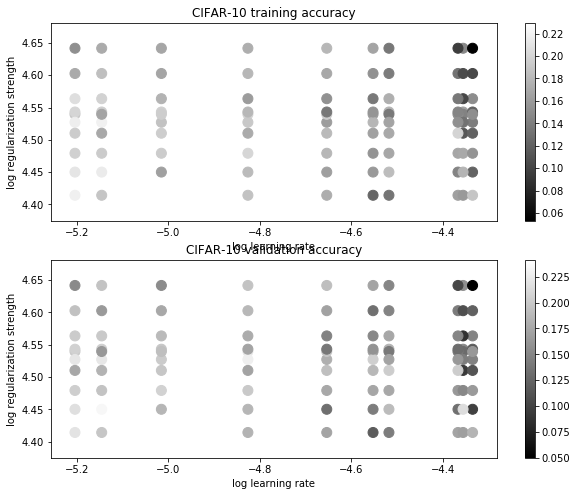

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.236000


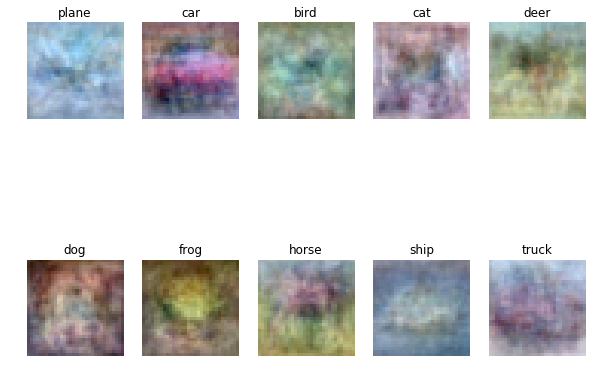

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *They're just blobs of color where the subject appeared to be. Horses have heads on both sides and no legs. Frogs are green. Highly color dependent. Orientation independent, but it might be problematic if the objects were sheared or rotated.*